In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import imageio
import json

from collections import Counter
from matplotlib.pyplot import figure
from matplotlib import animation

pdb_list, length_dict, input_features = np.load("datasets/sample-input-features.npy",allow_pickle=True)
pdb_list_y, distance_maps_cb = np.load("datasets/sample-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)

In [2]:
## aaron's code to get raw features from pdb

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
import time
import requests
import xml.etree.ElementTree as ET

# ! pip install biopython
# ! pip install nglview
# ! jupyter-nbextension enable nglview --py --sys-prefix

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

In [3]:
# aaron's code to make sure the folders are all in their proper place

dirlocal = os.path.curdir
data_path = os.path.join(dirlocal, 'Data/')
protein_path = os.path.join(data_path, 'Proteins/')
pdb_path = os.path.join(data_path, 'PDB/')
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(protein_path):
    os.makedirs(protein_path)
if not os.path.exists(pdb_path):
    os.makedirs(pdb_path)
ss_path = os.path.join(data_path, 'ss.txt')
feature_path = os.path.join(data_path, 'sample-input-features.npy')
distance_path = os.path.join(data_path, 'sample-distance-maps-cb.npy')
full_feature_path = os.path.join(data_path, 'full-input-features.npy')
full_distance_path = os.path.join(data_path, 'full-distance-maps-cb.npy')
test_feature_path = os.path.join(data_path, 'testset-input-features.npy')
test_distance_path = os.path.join(data_path, 'testset-distance-maps-cb.npy')

In [13]:
###  aaron's functions: 

# gets dataframe containing torsion angles, peptides, chain, etc
# from pdb file
def get_torsion_angles(pdb_id, degrees=False):
    pdb_struct = get_pdb_structure(pdb_id)
    torsion_angles = []
    for model in pdb_struct:
        for chain in model:
            polypeptides = PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                #print("Model %s Chain %s" % (str(model.id), str(chain.id)))
                #print("(part %i of %i)" % (poly_index+1, len(polypeptides)))
                #print("length %i" % (len(poly)))
                #print("from %s%i" % (poly[0].resname, poly[0].id[1]))
                #print("to %s%i" % (poly[-1].resname, poly[-1].id[1]))
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "%s%i" % (residue.resname, residue.id[1])
                    #print(res_name, tuple(math.degrees(b) for b in phi_psi[res_index] if b))
                    deg = phi_psi[res_index]
                    if degrees:
                        deg = tuple(math.degrees(b) if b else None for b in deg)
                    phi, psi = deg
                    model_name, model_id = model.full_id
                    torsion_angles.append([model_name, model_id, chain.id, residue.resname, residue.id[1], phi, psi])
    return pd.DataFrame(torsion_angles, columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name', 'Residue_ID', 'Phi', 'Psi'])


# generates ramachandran plot from a given pdb file
def ramachandran_plot(pdb_id, degrees=True):
    df = get_torsion_angles(pdb_id, degrees)
    x = df['Phi']
    y = df['Psi']
    # Generate plot
    plt.plot(x, y, ".")
    plt.title('Ramachandran Plot')
    if degrees:
        plt.xlabel(f'$\Phi$ Angle (Degrees)')
        plt.xlim(-180, 180)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-180, 180)
        plt.show()
    else:
        plt.xlabel(f'$\Phi$ Angle (Radians)')
        plt.xlim(-math.pi, math.pi)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-math.pi, math.pi)
        plt.show()

# helper function which generates a biopython structure
# for display in display_protein()
def get_pdb_structure(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
    try:
        struct = parser.get_structure(pdb_id,  file_path)
    except Exception as e:
        print(e)
        return None
    return struct


#  downloads the protein in question from pdb
def get_pdb_file(pdb_id):
    if pdb_id+".pdb" in os.listdir(pdb_path):
        return True
    
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    #print(url)
    resp = requests.get(url)
    try:
        file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
        #print(file_path)
        file = open(file_path, "wb")
        file.write(resp.content)
        file.close()
    except Exception as e: 
        print(e)
        return False
    return True

# neato 3d viewer of a protein's structure
def display_protein(pdb_id):
    pdb_struct = get_pdb_structure(pdb_id)
    view = nv.show_biopython(pdb_struct)
    return view

# helper function for get_secondary_structure
def find_protein_indexes(pdb_id):
    ss_txt = open(ss_path).read()
    ss_txt = ss_txt.replace('\n', "")
    ss = []
    offs = -1
    pdb_length = -1
    prev_seq = ''
    while True:
        offs = ss_txt.find(pdb_id, offs + 1)
        if offs == -1:
            break
        elif ss_txt[offs+7:offs+15] == 'sequence':
            next_offs = ss_txt.find(pdb_id, offs + 1)
            diff = next_offs - offs
            pdb_length = diff
            prev_seq = ss_txt[offs + 15:offs + pdb_length - 1]
        else:
            ss.append([ss_txt[offs+5], prev_seq, ss_txt[offs + 13:offs + pdb_length - 3]])
    return ss

#  returns a dataframe with secondary structure, amino acid code, chain id, etc
def get_secondary_structure(pdb_id):
    pdb_id=pdb_id.upper()
    indexes = find_protein_indexes(pdb_id)
    chain_df = []
    for i, chain_ss in enumerate(indexes):
        chain_id, seq, ss = chain_ss
        seq_list = [c for c in seq]
        ss_list = [c for c in ss]
        #print(seq_list + ss_list)
        chain_df.append(pd.DataFrame({'chain_id': chain_id, 'amino_acid':seq_list, 'secondary_structure':ss_list}))
    return pd.concat(chain_df)

In [21]:
# this generates the secondary structure ground truth proportions
# for a protein in a certain range(start,stop) of amino acids

def ss_ground_truth(protein_id, aa_range,secs):
    sstructs="HBEGITS"

    k=secs[secs['chain_id']==protein_id[4]]
    k=k.loc[aa_range,:]

    ss_count=[]

    for ss in sstructs:
        ss_count.append(len(k[k['secondary_structure']==ss])/len(k))

    return ss_count

# H = alpha helix
# B = residue in isolated beta-bridge
# E = extended strand, participates in beta ladder
# G = 3-helix (3/10 helix)
# I = 5 helix (pi helix)
# T = hydrogen bonded turn
# S = bend


# DON'T USE THIS
# its too intensive to call it over and over again
def format_torsion_angles_to_dataframe(pdb_id, start, chip_size):
    
    get_pdb_file(pdb_id)
    
    angles=[]
    ta=get_torsion_angles(pdb_id)

    angles+=list(ta.iloc[start:start+chip_size,:]["Phi"])
    angles+=list(ta.iloc[start:start+chip_size,:]["Psi"])
    
    return angles

def get_torsion_for_df(pdb_id):
    get_pdb_file(pdb_id)
    return get_torsion_angles(pdb_id)

In [48]:
#define functions

# mean function
# just for utility purposes
def mean(numlist):
    return sum(numlist)/len(numlist)

# this creates triangular chips along (but not including)
# the diagonal within the comparison matrix
def chip_diagonal(chip_size, step_size, aa_length):
    tri=[]
    for diag in range(0,aa_length-chip_size,step_size):
        tri.append(
            [(y,x) for y in range(diag,diag+chip_size) for x in range(y+1,chip_size+diag+1)]
        )
        # NB: y already has diag added to it
    return tri


# create a gif showing where the triangular chipping window is located
def gif_from_tri(protein_id,tri,filename):
    
    protein = np.array(distance_maps_cb[protein_id])
    l=len(protein)

    gif=[]

    for t in tri:
        new_test=np.ones((l,l))*0
        for (y,x) in t:
            new_test[y,x]=protein[y,x]

        im=plt.imshow(new_test)

        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=5)


# create a dataframe from a given protein id, chip size, and step size
def diag_chips_to_df(protein_id, chip_size, step_size):
    
    # arrange all the feature matrices into proper form so we can 
    # reference them properly later
    protein_dist = np.array(distance_maps_cb[protein_id])
    aa_length=len(protein_dist[0])
    
    protein_feat = np.array(input_features[protein_id])

    ccmpred=protein_feat[5].astype(np.float)
    ccmpred.shape=(aa_length,aa_length)
    
    freecontact=protein_feat[6].astype(np.float)
    freecontact.shape=(aa_length,aa_length)
    
    pstat_pots=protein_feat[7].astype(np.float)
    pstat_pots.shape=(aa_length,aa_length)
    
    chips=chip_diagonal(chip_size, step_size, aa_length)
    
    secs=get_secondary_structure(protein_id[0:4])
    
    # create column labels
    cols=["protein_id","chip_id"]
    cols+=["start","stop"]
    cols+=["dist_"+str(n) for n in range(0,len(chips[0]))]
    cols+=["psipred_helix","psipred_sheet","psipred_coil"]
    cols+=["psisolv","shannon_entropy"]
    cols+=["ccmpred","freecontact","pstat_pots"]
    cols+=["ground_truth_"+x for x in "HBEGITS"]
    cols+=["phi_"+str(x) for x in range(0,chip_size)]
    cols+=["psi_"+str(x) for x in range(0,chip_size)]

    
    chiplist=[]
    
    torsion_df=get_torsion_for_df(protein_id[0:4])
    t_phi=list(torsion_df['Phi'])
    t_psi=list(torsion_df['Psi'])
    
    # loop through all the chips
    for i in range(0,len(chips)):
        
        # row identifiers
        row=[protein_id,"chip_"+str(i)]
        row+=[i,i+chip_size]
        
        # inclusion range
        # between the first amino acid being compared 
        # and the last amino acid being compared
        # NB this assumes that 
        incl_range=range(min(min(chips[i])),max(max(chips[i])))
        
        # 1d features
        psipred_helix=mean(protein_feat[0].astype(np.float)[incl_range])
        psipred_sheet=mean(protein_feat[1].astype(np.float)[incl_range])
        psipred_coil=mean(protein_feat[2].astype(np.float)[incl_range])
        psisolv=mean(protein_feat[3].astype(np.float)[incl_range])
        shannon_entropy=mean(protein_feat[4].astype(np.float)[incl_range])
        
        # 2d features
        ccmpred_pool=[]
        freecontact_pool=[]
        pstat_pool=[]
        
        # ss ground truth
        ssgt=ss_ground_truth(protein_id,incl_range,secs)
        
        # loop through each pixel in the chip
        for n in range(0,len(chips[i])):
            
#             make sure we're not on the diagonal
#             print([chips[i][n][0],chips[i][n][1]])
            
            row.append(
                protein_dist[chips[i][n][0],chips[i][n][1]]
            )
            ccmpred_pool.append(
                ccmpred[chips[i][n][0],chips[i][n][1]]
            )
            freecontact_pool.append(
                freecontact[chips[i][n][0],chips[i][n][1]]
            )
            pstat_pool.append(
                pstat_pots[chips[i][n][0],chips[i][n][1]]
            )
            
        # 1d features
        row.append(psipred_helix)
        row.append(psipred_sheet)
        row.append(psipred_coil)
        row.append(psisolv)
        row.append(shannon_entropy)
   
        # 2d features
        row.append(max(ccmpred_pool))
        row.append(max(freecontact_pool))
        row.append(max(pstat_pool))
        
        # ground truth
        [row.append(x) for x in ssgt]
        
        # torsional angles
        row+=t_phi[i:i+chip_size]
        row+=t_psi[i:i+chip_size]
        
#         print(row)
        
        # add to df
        chiplist.append(row)

#     AssertionError: 94 columns passed, passed data had 75 columns
# almost correct number of columns, but torsion angles not being passed correctly?
    chip_df=pandas.DataFrame(chiplist,columns=cols)

    return chip_df


# compute the ground truth secondary structure
# of which the majority of amino acids in a window
# are a part of
# i.e. that whose percentage within the window is above 50%
def compute_majority_ss(df):
    for ss in "HBEGITS":
        df["maj_"+ss]=df['ground_truth_'+ss]>.5
    return df


In [7]:
# some variable sizes

chip_size=10
step_size=1


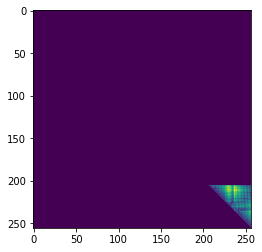

In [8]:
# demonstrate the gif function

gif_from_tri("1hzfA0",chip_diagonal(50,1,256),"chiptri_diag")

In [50]:
# demonstrate how to create a dataset from it

dataset=pandas.concat([(diag_chips_to_df(pid,10,1)) for pid in pdb_list_y[0:10]])
compute_majority_ss(dataset)

dataset
# dataset.to_csv("datasets/protein_test_fifteen_gt.csv")

protein_id  chip_id  start  stop    dist_0    dist_1     dist_2     dist_3  \
0      12asA0   chip_0      0    10  5.143815  4.915550   4.319084   6.744481   
1      12asA0   chip_1      1    11  5.229357  7.207812   6.051126   6.068776   
2      12asA0   chip_2      2    12  5.225279  7.435200   5.658430   6.531425   
3      12asA0   chip_3      3    13  5.128916  7.102418   6.122839   6.502397   
4      12asA0   chip_4      4    14  5.413692  7.283288   5.210369   6.532245   
5      12asA0   chip_5      5    15  5.071629  7.101260   5.998107   6.628094   
6      12asA0   chip_6      6    16  5.544371  7.292204   5.638320   6.551408   
7      12asA0   chip_7      7    17  5.235345  7.296628   6.080991   6.637707   
8      12asA0   chip_8      8    18  5.218982  7.377527   6.045736   6.281882   
9      12asA0   chip_9      9    19  5.350801  7.368221   6.169512   5.926985   
10     12asA0  chip_10     10    20  5.281722  7.547689   5.855772   5.989973   
11     12asA0  chip_11     11    21  5.145443  7.102318   6.152756   6.241337   
12     12asA0  chip_12     12    22  5.219878  7.674682   6.485016   6.283516   
13     12asA0  chip_13     13    23  5.278492  7.405928   5.408425   6.996410   
14     12asA0  chip_14     14    24  5.170594  6.992202   5.901788   6.464631   
15     12asA0  chip_15     15    25  5.580253  7.187028   4.595514   6.595624   
16     12asA0  chip_16     16    26  5.277092  7.048139   5.928366   6.921511   
17     12asA0  chip_17     17    27  5.570306  7.214351   5.622976   6.137299   
18     12asA0  chip_18     18    28  5.307587  7.467853   6.614203   5.765007   
19     12asA0  chip_19     19    29  5.225220  7.676689   6.620859   5.728398   
20     12asA0  chip_20     20    30  5.071460  7.702156   7.337254   5.739205   
21     12asA0  chip_21     21    31  5.303972  7.900186   6.803007   9.072074   
22     12asA0  chip_22     22    32  4.906746  7.223030   8.787084  13.278381   
23     12asA0  chip_23     23    33  4.813674  5.119860  10.432542  12.342718   
24     12asA0  chip_24     24    34  4.759153  7.382706  10.983126  12.526223   
25     12asA0  chip_25     25    35  5.770321  7.605846   8.767790  13.798241   
26     12asA0  chip_26     26    36  5.511334  6.517975  10.957323  12.987772   
27     12asA0  chip_27     27    37  5.726915  8.016840   9.206738  13.816153   
28     12asA0  chip_28     28    38  5.590977  7.295848   9.950081  13.606741   
29     12asA0  chip_29     29    39  5.772480  7.972021  10.281793  12.920188   
..        ...      ...    ...   ...       ...       ...        ...        ...   
40     1am9A0  chip_40     40    50  5.225035  7.326788   5.668981   6.639014   
41     1am9A0  chip_41     41    51  5.454658  7.180612   5.740982   6.170759   
42     1am9A0  chip_42     42    52  5.458068  7.366449   5.320845   6.230594   
43     1am9A0  chip_43     43    53  5.211490  7.170731   5.733016   6.292373   
44     1am9A0  chip_44     44    54  5.387476  7.110072   5.183927   6.437855   
45     1am9A0  chip_45     45    55  5.223892  7.156486   5.866929   6.636803   
46     1am9A0  chip_46     46    56  5.334247  7.174337   6.003907   5.736809   
47     1am9A0  chip_47     47    57  5.259498  7.521678   5.634936   6.379275   
48     1am9A0  chip_48     48    58  5.108843  7.154339   6.059738   6.718634   
49     1am9A0  chip_49     49    59  5.411945  7.345860   5.598150   6.232913   
50     1am9A0  chip_50     50    60  5.405169  7.236936   5.527779   6.194942   
51     1am9A0  chip_51     51    61  5.303788  7.211797   5.492513   6.197954   
52     1am9A0  chip_52     52    62  5.267885  7.219021   5.498337   6.188354   
53     1am9A0  chip_53     53    63  5.373533  7.100634   5.673546   5.896886   
54     1am9A0  chip_54     54    64  5.276817  7.365875   5.498390   6.156407   
55     1am9A0  chip_55     55    65  5.137423  7.037964   5.767105   6.758052   
56     1am9A0  chip_56     56    66  5.282451  7.247251   5.821985   6.354646   
57     1am9A0  chip_57     57    6

In [49]:
# dataset=pandas.concat([(diag_chips_to_df(pid,10,1)) for pid in pdb_list_y[0:1]])
# diag_chips_to_df(pdb_list_y[0],10,1)

# get_torsion_for_df(pdb_list_y[0][0:4])


protein_id   chip_id  start  stop    dist_0    dist_1     dist_2  \
0       12asA0    chip_0      0    10  5.143815  4.915550   4.319084   
1       12asA0    chip_1      1    11  5.229357  7.207812   6.051126   
2       12asA0    chip_2      2    12  5.225279  7.435200   5.658430   
3       12asA0    chip_3      3    13  5.128916  7.102418   6.122839   
4       12asA0    chip_4      4    14  5.413692  7.283288   5.210369   
5       12asA0    chip_5      5    15  5.071629  7.101260   5.998107   
6       12asA0    chip_6      6    16  5.544371  7.292204   5.638320   
7       12asA0    chip_7      7    17  5.235345  7.296628   6.080991   
8       12asA0    chip_8      8    18  5.218982  7.377527   6.045736   
9       12asA0    chip_9      9    19  5.350801  7.368221   6.169512   
10      12asA0   chip_10     10    20  5.281722  7.547689   5.855772   
11      12asA0   chip_11     11    21  5.145443  7.102318   6.152756   
12      12asA0   chip_12     12    22  5.219878  7.674682   6.485016   
13      12asA0   chip_13     13    23  5.278492  7.405928   5.408425   
14      12asA0   chip_14     14    24  5.170594  6.992202   5.901788   
15      12asA0   chip_15     15    25  5.580253  7.187028   4.595514   
16      12asA0   chip_16     16    26  5.277092  7.048139   5.928366   
17      12asA0   chip_17     17    27  5.570306  7.214351   5.622976   
18      12asA0   chip_18     18    28  5.307587  7.467853   6.614203   
19      12asA0   chip_19     19    29  5.225220  7.676689   6.620859   
20      12asA0   chip_20     20    30  5.071460  7.702156   7.337254   
21      12asA0   chip_21     21    31  5.303972  7.900186   6.803007   
22      12asA0   chip_22     22    32  4.906746  7.223030   8.787084   
23      12asA0   chip_23     23    33  4.813674  5.119860  10.432542   
24      12asA0   chip_24     24    34  4.759153  7.382706  10.983126   
25      12asA0   chip_25     25    35  5.770321  7.605846   8.767790   
26      12asA0   chip_26     26    36  5.511334  6.517975  10.957323   
27      12asA0   chip_27     27    37  5.726915  8.016840   9.206738   
28      12asA0   chip_28     28    38  5.590977  7.295848   9.950081   
29      12asA0   chip_29     29    39  5.772480  7.972021  10.281793   
..         ...       ...    ...   ...       ...       ...        ...   
216     12asA0  chip_216    216   226  5.975560  6.456459   5.382954   
217     12asA0  chip_217    217   227  5.190706  8.511385  11.278729   
218     12asA0  chip_218    218   228  5.780276  8.289587  10.402715   
219     12asA0  chip_219    219   229  5.677042  6.984308  10.773120   
220     12asA0  chip_220    220   230  5.879113  8.471182   8.304535   
221     12asA0  chip_221    221   231  5.214017  3.921454   6.039211   
222     12asA0  chip_222    222   232  5.793549  6.763161  10.126372   
223     12asA0  chip_223    223   233  4.611425  5.763996   9.119545   
224     12asA0  chip_224    224   234  4.627536  8.335895   9.493217   
225     12asA0  chip_225    225   235  5.171152  6.850763  10.673671   
226     12asA0  chip_226    226   236  4.563584  8.863856  10.279648   
227     12asA0  chip_227    227   237  4.761633  6.047154   8.270593   
228     12asA0  chip_228    228   238  5.570684  8.505133  13.244275   
229     12asA0  chip_229    229   239  4.324419  8.526795  11.583791   
230     12asA0  chip_230    230   240  4.777222  7.968455   9.155345   
231     12asA0  chip_231    231   241  5.560097  5.370771  10.274206   
232     12asA0  chip_232    232   242  5.786385  7.283390  12.018411   
233     12asA0  chip_233    233   243  5.820382  8.334740   9.774721   
234     12asA0  chip_234    234   244  5.243722  6.332487   8.996051   
235     12asA0  chip_235    235   245  5.987904  5.958268   9.939608   
236     12asA0  chip_236    236   246  5.847925  5.489387   3.807672   
237     12asA0  chip_237    237   247  5.635461  7.496430   6.307090   
238     12asA0  chip_238    238   248  5.205071  7.275207   9.091979   
239     12asA0  chip_239    239   249  5.645

In [ ]:
# this will add majority secondary structure to the dataframe
# through loading it from file
# i've dummied it out through the if statement but its still usefull
if False:
    dataset=pandas.read_csv("datasets/protein_full_gt.csv")

    compute_majority_ss(dataset)
    dataset.to_csv("datasets/protein_full_gt_classed.csv")



In [ ]:
# these generate triangular numbers from a row number
# and row numbers from a triangular number
# not sure if I use them anymore but here they are
def tri_num(x):
    return x*(x+1)/2
    
def inv_tri_num(x):
    for i in range(0,x):
        if tri_num(i)>x:
            return None
        if tri_num(i)==x:
            return i    

In [ ]:
# this draws a gif from a number of chips l
# which will iterate through the rows of a datafile
# and make each row (and the chip represented by that row)
# into a frame of the gif
def gif_from_chips(dataset,l,filename):    

    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    gif=[]

    for n in range(0,l):
        
        chpx=list(df.iloc[n,:])

        chip_l=inv_tri_num(ncol)+1
        chp_im=np.zeros((chip_l,chip_l))
        triu=np.triu_indices(chip_l,1)
        tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]

        for i in range(0,len(tri_ind)):
             chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

        im=plt.imshow(chp_im)    

        
        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=60)

    
    
# this is a function which will draw the average chip
# of a dataset
# i.e. draw a chip whose pixels are each an average of the
# pixels in that position on each chip
def draw_avg_chip(dataset, name, max_dist):
    
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
#     print(ncol)
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.zeros((chip_l,chip_l))
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

    im=plt.imshow(chp_im,vmax=max_dist)
    
    x=im.make_image("AGG")[0]
    x=np.flipud(x)
    
    imageio.imsave("plots/"+name+".png", x)
    
# as above, but draws a lineplot instead of a chip
def draw_avg_dist_lineplot(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]-tri_ind[i][0]]=chpx[i]

    plt.ylim((0, max_dist))
    plt.plot(np.nanmean(chp_im,0))
    
    plt.savefig("plots/lineg/"+name+".png")
    plt.cla()

# as above, but draws a densityplot instead of a lineplot
def draw_avg_dist_densityplot(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    chpx=list(df.mean(0))
    
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)
    seq_dist=[triu[1][i]-triu[0][i] for i in range(0,len(triu[0]))]
    
    cx=[]
    cy=[]

    for index, row in df.iterrows():
        for i in range(0,len(seq_dist)):
            cx.append(seq_dist[i])
            cy.append(row[i])

    plt.ylim((0, max_dist))

    plt.hist2d(cx,cy)
 
    plt.savefig("plots/2dhist/"+name+".png")
    plt.cla()
    
    
    # as above, but draws a densityplot which does not have an
    # artificially brightened area for lower amino acid sequence distances
    # because we average across sequence distance per chip
    # before averaging across chips
def draw_avg_dist_densityplot2(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
        
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)

    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    cx=[]
    cy=[]
    
    for index, row in df.iterrows():
        for i in range(0,chip_l):
            chp_im[tri_ind[i][0],tri_ind[i][1]-tri_ind[i][0]]=row[i]
        
        cx+=(list(range(1,chip_l)))
        cy+=list(np.nanmean(chp_im,0))[1:]

    xbins=np.linspace(1,chip_l,chip_l)
    ybins=np.linspace(1,max_dist,chip_l*2)
    

    plt.hist2d(cx,cy,bins = (xbins,ybins))
 
    plt.savefig("plots/2dhist/"+name+".png")
    
def get_avg_distances(dataset):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    return(list(df.mean(0)))

In [ ]:
dataset=pandas.read_csv("datasets/protein_test_gt.csv")


draw_avg_dist_densityplot2(dataset.iloc[0:100,:],"test",30)

In [ ]:
# read in the dataset to use below
dataset=pandas.read_csv("datasets/protein_test_gt.csv")


# IMPORTANT
# this is the maximum value found in the distance matrix, which lets us
# compare different segmentation-generated avg chips because they all have the same
# color scale (as opposed to the locally normalized color scale used by default)
# max_dist=dataset[["dist_"+str(x) for x in range(0,ncol)]].max().max()
 

In [ ]:
# demonstrate the gif_from_chips function
# which draws an animated gif of a number of chips from a saved dataset

gif_from_chips(dataset,500,"chip_draw")

In [ ]:
# this draws the avg distance for each pixel in all chips
# within each point in a thd dendrogram

def draw_thd_segmentations(folder,prefix,dataset):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:len(prefix)]==prefix]
        
    df_list=[]
    names=[]
    maxes=[]
    
    for model in thds:
        
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)
            
            df=dataset.iloc[[int(m) for m in a['rowList']],:]
            
#             print(model)
#             print([int(m) for m in a['rowList']])
            
            maxes.append(max(get_avg_distances(df)))
            df_list.append(df)
            names.append(model[len(prefix):len(model)-5])
            
    max_dist=max(maxes)
    for i in range(0,len(df_list)):
#         draw_avg_chip(df_list[i],names[i],max_dist)
#         draw_avg_dist_lineplot(df_list[i],names[i],max_dist)
#         draw_avg_dist_densityplot(df_list[i],names[i],max_dist)
        draw_avg_dist_densityplot2(df_list[i],names[i],max_dist)

def thd_row_lengths(folder,prefix):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:len(prefix)]==prefix]
    
    d={}
    
    for model in thds:
        
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)

            d[model]=a['meta']['row_count']
    
    for i in d:
        print(i +" "+ str(round(d[i]/max(d.values()),2)))

        

In [ ]:
# demonstrate draw_thd_segmentations

#     draw_thd_segmentations("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ",dataset)
# thd_row_lengths("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ")

#     draw_thd_segmentations("THD_test_Absolute Correlation_protein_test_fifteen_gt.csv_2019.06.19 14.20.55/","THD_test ",dataset)

In [ ]:
# testing aaron's functions

get_torsion_angles("1a0t")

# ramachandran_plot("1a0t")


# get_pdb_file("1hzf")
# get_secondary_structure("1hzf")

# find_protein_indexes("1hzf")

In [ ]:
add_torsion_angles_to_dataframe("1a0t",0,10)

In [ ]:
dataset

In [12]:
os.listdir(pdb_path)

['12AS.pdb',
 '16PK.pdb',
 '16VP.pdb',
 '1A0T.pdb',
 '1A2Z.pdb',
 '1HZF.pdb',
 '1HZFA0.pdb',
 'AAAA.pdb']